In [1]:
# Translation of script_nd_sphere.m (lines 1-68) to Python
import numpy as np

# Set random seed for reproducibility (optional)
np.random.seed(0)

# Sample 500 points from a 3D Gaussian (as in the MATLAB code)
n = 500
d = 2
lambda_ = 1
u = np.random.normal(0, 1, (n, d))
u[:, 0] = lambda_ * u[:, 0]
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(n, 1)) * 1/100 + 99/100
u_trans = u / u_norm

# X_tar = r * u_trans (element-wise multiplication)
X_tar = r * u_trans
# n = X_tar.shape[0] (already n=500, but keep for consistency)
n = X_tar.shape[0]

# Form the anisotropic graph Laplacian inputs
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / np.log(n + 1)
# Kernel function
def ker(X):
    sq_tar = np.sum(X ** 2, axis=1)
    return np.exp(-(sq_tar[:, None] + sq_tar[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)
# Degree-like quantities needed by grad_ker1 / K_tar_eval
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()


In [2]:
# EDMD with Brownian time pairs matched to kernel epsilon (thin shell)
import numpy as np

# 1) Build Brownian pairs on the thin shell: Y = r * normalize(X + sigma * xi_tan)
# sigma chosen to match kernel bandwidth: epsilon ≈ 2 D dt, take D=1 => dt = epsilon/2, sigma = sqrt(epsilon)
D_edmd = 1.0
Delta_t = epsilon / (2.0 * D_edmd)
sigma = np.sqrt(epsilon)
# optional tiny correction for tangent dimensionality (d-1) vs ambient d; can be commented
if d > 1:
    sigma = sigma * np.sqrt(d / (d - 1))

rng = np.random.default_rng()
Xi = rng.normal(0.0, 1.0, size=X_tar.shape)
# project noise to tangent plane at each X_tar
proj = np.sum(Xi * X_tar, axis=1, keepdims=True)
Xi_tan = Xi - proj * X_tar
Y_pairs = X_tar + sigma * Xi_tan
# renormalize back to original radius (thin shell)
radius = np.linalg.norm(X_tar, axis=1, keepdims=True) + 1e-12
Y_pairs = Y_pairs / (np.linalg.norm(Y_pairs, axis=1, keepdims=True) + 1e-12) * radius

# 2) Build sample-space EDMD transition K_data using Gaussian responsibilities to anchors X_tar
#    W[k,j] ∝ exp(-||Y_k - X_tar_j||^2 / (2*epsilon)); K_data[i,:] accumulates from the nearest anchor of X_k
# find nearest anchor for each X_tar point itself (identity), or use true nearest; since anchors are X_tar, src indices are 0..n-1
# For robustness if X_tar has duplicates, we still compute NN
try:
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(X_tar)
    src_idx = nn.kneighbors(X_tar, return_distance=False).ravel()
except Exception:
    # fallback: identity mapping
    src_idx = np.arange(n)

sqA = np.sum(X_tar**2, axis=1)                 # (n,)
sqY = np.sum(Y_pairs**2, axis=1)               # (n,)
# responsibilities from Y to anchors
W = np.exp(-(sqY[:, None] + sqA[None, :] - 2.0 * (Y_pairs @ X_tar.T)) / (2.0 * epsilon))
W = W / (np.sum(W, axis=1, keepdims=True) + 1e-12)

K_count = np.zeros((n, n))
for k in range(n):
    i = src_idx[k]
    K_count[i, :] += W[k, :]
# row-normalize to get a Markov matrix
row_sums = np.sum(K_count, axis=1, keepdims=True) + 1e-12
K_data = K_count / row_sums

# 3) Symmetrize and eigendecompose
K_sym = 0.5 * (K_data + K_data.T)
K_sym = np.clip(K_sym, 0.0, 1.0)

# eigen-decomposition (symmetric)
s_edmd, phi_edmd = np.linalg.eigh(K_sym)  # s_edmd ascending
order = np.argsort(-s_edmd)
s_edmd = s_edmd[order]
phi_edmd = phi_edmd[:, order]

# 4) Continuous-time generator eigenvalues: mu = log(s)/Delta_t
s_safe = np.clip(s_edmd, 1e-12, 1.0)
mu_edmd = np.log(s_safe) / Delta_t

# Build inverse-like weights for iteration
reg_mu = 1e-3
above_tol_mask = np.abs(mu_edmd) > 1e-10
above_tol = int(np.sum(above_tol_mask))
inv_mu = np.zeros_like(mu_edmd)
inv_mu[above_tol_mask] = 1.0 / (mu_edmd[above_tol_mask] + reg_mu * np.sign(mu_edmd[above_tol_mask]))
cap = 1e3
lambda_ns_s_ns = np.minimum(np.abs(inv_mu[:above_tol]), cap)

# Expose generic variables expected by iteration
phi = phi_edmd


In [3]:
# Import the translated kernel and gradient functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

In [4]:
# Translation of script_nd_sphere.m lines 75-139 to Python
# Assumes grad_ker1 and K_tar_eval are already implemented and imported

iter = 1000
h = 5
m = 700

# Initialize particles
u = np.random.normal(0, 1, (m, d))
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(m, 1)) * 1/100 + 99/100
u_trans = u / u_norm
x_init = r * u_trans
x_init = x_init[x_init[:, 1] > 0.7, :]
m = x_init.shape[0]
x_t = np.zeros((m, d, iter))
x_t[:, :, 0] = x_init

# Precompute quantities
p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

# EDMD spectral variables are provided by the EDMD cell: phi, above_tol, lambda_ns_s_ns

sum_x = np.zeros((m, d))
for t in range(iter - 1):
    grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
    cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
    for i in range(d):
        sum_x[:, i] = np.sum(grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix, axis=1)
    x_t[:, :, t + 1] = x_t[:, :, t] - h / m * sum_x


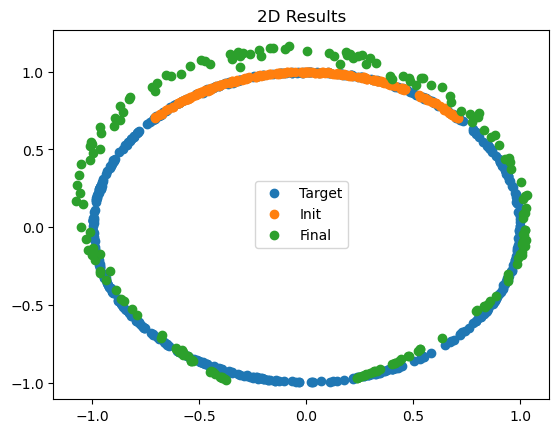

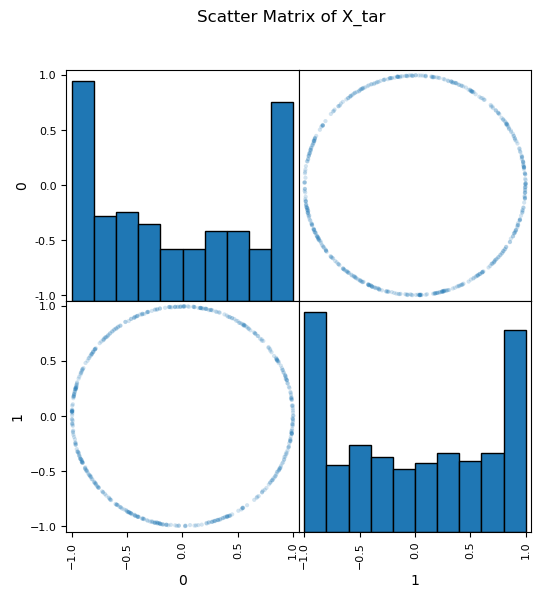

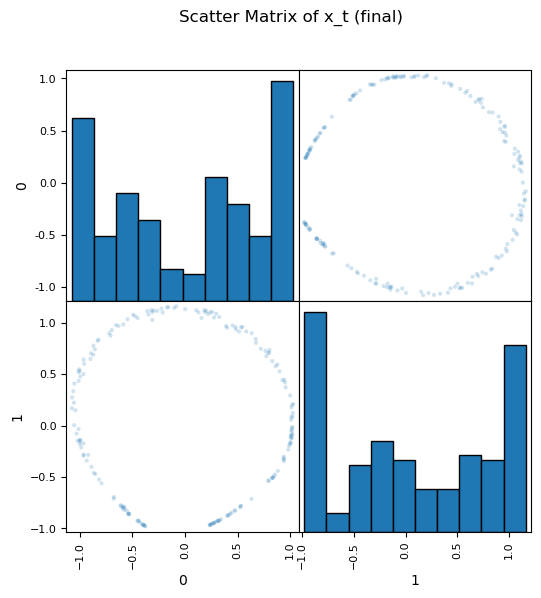

In [5]:
# Translation of script_nd_sphere.m lines 144-168 to Python
import pandas as pd
import matplotlib.pyplot as plt


# Plotting results
if d == 2:
    plt.figure()
    plt.plot(X_tar[:, 0], X_tar[:, 1], 'o', label='Target')
    plt.plot(x_t[:, 0, 0], x_t[:, 1, 0], 'o', label='Init')
    plt.plot(x_t[:, 0, -1], x_t[:, 1, -1], 'o', label='Final')
    plt.legend()
    plt.title('2D Results')
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], label='Target')
    ax.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax.legend()
    plt.title('3D Results')
    plt.show()
    # Additional plot for final state only
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax2.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax2.legend()
    plt.title('3D Final State')
    plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of X_tar')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1]),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of x_t (final)')
plt.show()